# Test Dataloader in dataset.py

In [1]:
# install packages
import yaml
import os
import json
import torch
from torch.utils.data import Dataset
from torch import randint
from torchmetrics.functional.segmentation import mean_iou
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools import mask as coco_mask
from pycocotools.coco import COCO
import numpy as np
from sharkbody_seg.dataset import SharkBody



Import Data/Annotations

In [2]:
config_file_path = '/home/Alexandra/Projects/bodycondition/sharkbody_seg/runs/unet_smp/crop_center/config/config.yaml' # config file path
with open(config_file_path, 'r') as file: cfg = yaml.safe_load(file) # load yaml as cfg

Functions from earth_obs_seg (Bjorn)

# Test each function

In [3]:
# instantiate shark body
dataset = SharkBody(cfg, split='train')

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [4]:
# check for missing center coordinates
for i in range(len(dataset)):
    sample = dataset[i]
    image_name = sample['filename']
    
    # Get center coordinates for the image
    center_y, center_x = dataset.center_dict.get(image_name, (None, None))
    
    # If the center coordinates are None, add the image to the list
    if center_y is None or center_x is None:
        print(image_name)

Images without center coordinates:
07202023PANB0803.JPG
12132023PAMB0201.JPG
12032024PAAN0504.JPG


In [16]:
# test data loader
for i in range(200):
    print(dataset[i])  # Should print (image_tensor, label)

{'image': tensor([[[0.3451, 0.3490, 0.3451,  ..., 0.3451, 0.3412, 0.3412],
         [0.3412, 0.3412, 0.3412,  ..., 0.3451, 0.3412, 0.3451],
         [0.3333, 0.3333, 0.3333,  ..., 0.3451, 0.3451, 0.3412],
         ...,
         [0.3137, 0.3137, 0.3216,  ..., 0.3216, 0.3137, 0.3137],
         [0.3137, 0.3137, 0.3216,  ..., 0.3216, 0.3137, 0.3176],
         [0.3176, 0.3137, 0.3216,  ..., 0.3216, 0.3176, 0.3216]],

        [[0.5216, 0.5255, 0.5255,  ..., 0.5333, 0.5294, 0.5294],
         [0.5216, 0.5216, 0.5216,  ..., 0.5333, 0.5294, 0.5333],
         [0.5216, 0.5216, 0.5216,  ..., 0.5294, 0.5333, 0.5294],
         ...,
         [0.5098, 0.5098, 0.5176,  ..., 0.5176, 0.5176, 0.5176],
         [0.5098, 0.5098, 0.5176,  ..., 0.5137, 0.5098, 0.5137],
         [0.5137, 0.5098, 0.5176,  ..., 0.5137, 0.5098, 0.5137]],

        [[0.4314, 0.4353, 0.4353,  ..., 0.4392, 0.4353, 0.4353],
         [0.4275, 0.4314, 0.4275,  ..., 0.4392, 0.4392, 0.4392],
         [0.4275, 0.4275, 0.4275,  ..., 0.4353, 

IndexError: list index out of range

In [6]:
# test len function
print(len(dataset)) 

2


In [7]:
# test the __getitem__ function
sample = dataset[0]
img_tensor = sample['image']  
mask_tensor = sample['mask'] 

sample

{'image': tensor([[[0.3451, 0.3490, 0.3451,  ..., 0.3451, 0.3412, 0.3412],
          [0.3412, 0.3412, 0.3412,  ..., 0.3451, 0.3412, 0.3451],
          [0.3333, 0.3333, 0.3333,  ..., 0.3451, 0.3451, 0.3412],
          ...,
          [0.3137, 0.3137, 0.3216,  ..., 0.3216, 0.3137, 0.3137],
          [0.3137, 0.3137, 0.3216,  ..., 0.3216, 0.3137, 0.3176],
          [0.3176, 0.3137, 0.3216,  ..., 0.3216, 0.3176, 0.3216]],
 
         [[0.5216, 0.5255, 0.5255,  ..., 0.5333, 0.5294, 0.5294],
          [0.5216, 0.5216, 0.5216,  ..., 0.5333, 0.5294, 0.5333],
          [0.5216, 0.5216, 0.5216,  ..., 0.5294, 0.5333, 0.5294],
          ...,
          [0.5098, 0.5098, 0.5176,  ..., 0.5176, 0.5176, 0.5176],
          [0.5098, 0.5098, 0.5176,  ..., 0.5137, 0.5098, 0.5137],
          [0.5137, 0.5098, 0.5176,  ..., 0.5137, 0.5098, 0.5137]],
 
         [[0.4314, 0.4353, 0.4353,  ..., 0.4392, 0.4353, 0.4353],
          [0.4275, 0.4314, 0.4275,  ..., 0.4392, 0.4392, 0.4392],
          [0.4275, 0.4275, 0.42

In [8]:
sample["mask"].dtype

torch.float32

In [9]:
sample = dataset[0]
sample['relative_altitude']

13.8

In [10]:
# check dimensions of tensors

print(f"Image dimensions: {img_tensor.shape if hasattr(img_tensor, 'shape') else img_tensor.size()}") 

# Check the dimensions of the mask
print(f"Mask dimensions: {mask_tensor.shape if hasattr(mask_tensor, 'shape') else mask_tensor.size()}")  


Image dimensions: torch.Size([3, 224, 224])
Mask dimensions: torch.Size([1, 224, 224])


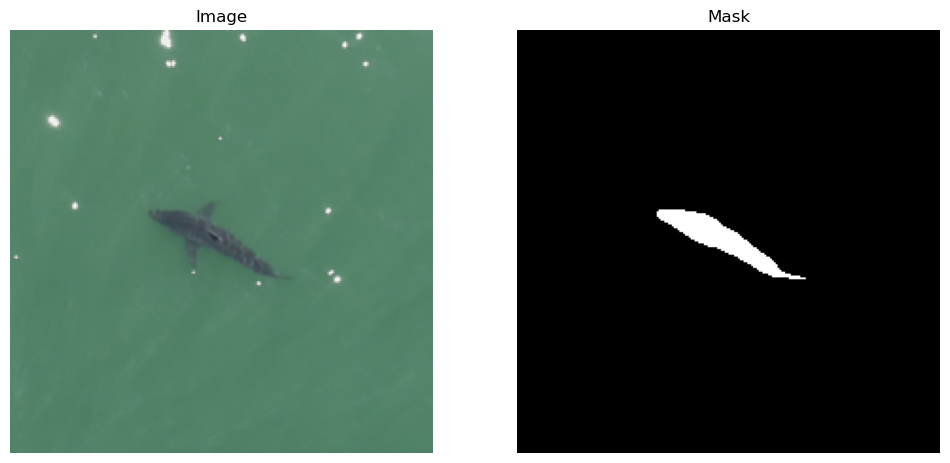

In [13]:
sample = dataset[1]
img_tensor = sample['image']  
mask_tensor = sample['mask'] 

# check plots 
img_display = img_tensor.numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
mask_display = mask_tensor.squeeze(0).numpy()  # Convert from (1, H, W) to (H, W)

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # two subplots

# image plot
axes[0].imshow(img_display)
axes[0].set_title("Image")
axes[0].axis('off') 

# mask plot
axes[1].imshow(mask_display, cmap='gray')  # Use 'gray' colormap for mask
axes[1].set_title("Mask")
axes[1].axis('off') 

plt.show()
